https://www.tensorflow.org/text/tutorials/word_embeddings


In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

In [2]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from keras.layers import TextVectorization
from keras.optimizers import Adam

import io
import os
import re
import shutil
import string

import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

tf.__version__,keras.__version__
# ('2.15.1', '2.15.0')

('2.18.0', '3.8.0')

# Word embeddings

감정 분류 작업을 위해 자신만의 단어 임베딩을 훈련하고,  
이를 [Embedding Projector](http://projector.tensorflow.org)에서 시각화   

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Representing text as numbers
- model은 vector를 입력으로 사용  
- 가장 먼저, 문자열을 숫자로 변환(또는 텍스트를 "벡터화")하는 전략을 준비해야 함  
- 기본적인 3가지 전략 살펴보기  


### 1) One-hot encodings  
-  비효율적임  
-  인코딩된 벡터는 sparce하여 1000개의 단어에서 99.9%가 0 값을 갖게 됨

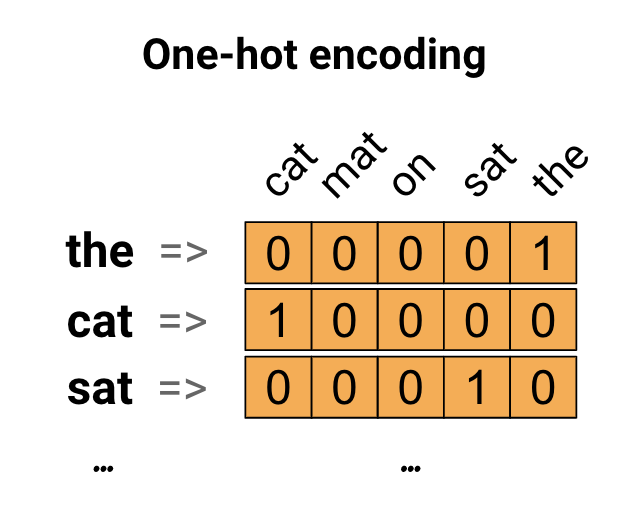

### 2) Encode each word with a unique number
- 각각의 단어에 일련 번호를 할당  
- 두가지 중요한 단점을 가짐  
 1) 단어 간의 관계를 표현하지 못함  
 2) 모델이 해석(학습)하기 어려움  
  -  선형 분류기에서 입력(feature)에 대해 하나의 weight를 학습하는데,feature-weight 조합은 의미가 없음  


### Word embeddings
- 유사한 단어가 유사한 인코딩 값(표현,embedding vector)을 갖도록 함  
- Dense layer의 weight 학습을 통해 embeding vector를 mapping함  
- 8-dim(작은 데이터 세트의 경우)에서 1024-dim(대규모 데이터 세트)사용함  
- 학습한 후에는 table에서 해당하는 벡터를 찾아 각 단어를 인코딩  
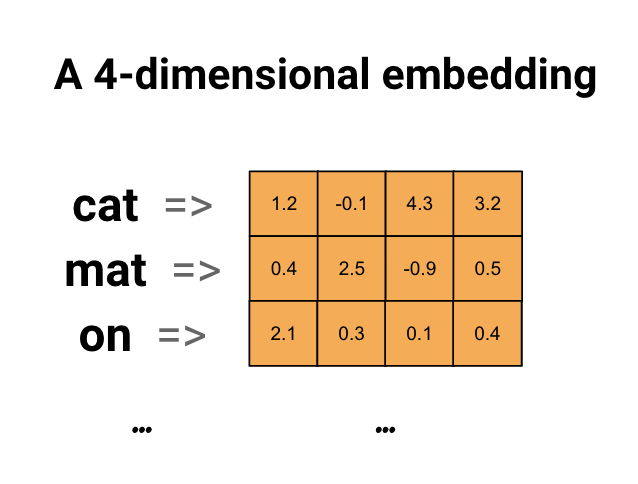


## Dataset 준비  

### Download the IMDb Dataset
- [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)에서 positive, negative로 labeling된 review로 이진 분류 학습  

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

#dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir = os.path.join(dataset, 'aclImdb')
dataset_dir, os.listdir(dataset_dir)

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


('./aclImdb_v1_extracted/aclImdb',
 ['train', 'README', 'imdb.vocab', 'imdbEr.txt', 'test'])

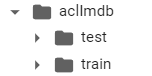

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_neg.txt',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'unsupBow.feat',
 'unsup']

`train` directory 사용하지 않을 'unsup'제거

In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

`tf.data.Dataset` 준비   
- 20%는 validation dataset으로 분리  

In [6]:
batch_size = 256
seed = 123
train_ds = keras.utils.text_dataset_from_directory( dataset_dir+'/train',
    batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = keras.utils.text_dataset_from_directory(  dataset_dir+'/train',
    batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Dataset 확인




In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

### Data load 성능 개선  
`.cache()` :데이터를 로드하여 메모리에 보관  
`.prefetch()` : 학습중, 데이터 전처리와 모델 실행이 overlap  


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터를 캐싱하는 코드

### Embedding layer 준비
- 단어 인덱스를 dense vector로 mapping하는 lookup table역할을 함
- vector dimension은 실험적으로 결정할 parameter임  
- random으로 초기화 되고, 학습과정에서 단어간 유사성에 따라 변경됨  

In [9]:
## Embed a 1,000 word vocabulary into 5 dimensions.
## index(max 1000) to 5-dim vector
embedding_layer = keras.layers.Embedding(1000, 5)
result = embedding_layer(tf.constant([1, 2, 3])) #1,2,3: word idx

result #(3,5):(seq., dim)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[-0.0267959 ,  0.0192687 ,  0.02524226, -0.04580282,  0.01201856],
       [-0.03232505,  0.01477319, -0.04443097, -0.02432439, -0.02361704],
       [ 0.04553676,  0.03614512, -0.0262658 , -0.04969412,  0.02979238]],
      dtype=float32)>

Embedding 레이어
- (samples, sequence_length) 정수로 구성된 2D 텐서  
- 가변 길이의 시퀀스 포함  
- (32, 10): (길이가 10인 32개의 배치)
- return은 (32, 10, 5:vec-dim)  

In [10]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]])) #(2,3)
result.shape #(2,3,5)

TensorShape([2, 3, 5])

### Text preprocessing

`keras.layers.TextVectorization` Layer를 사용하여  
- standardize, tokenize, vectorize 함   

`standardize` : 구두점이나 HTML 요소를 제거, 데이터를 단순화 하기    
`tokenize` : 문자열을 여러 토큰(단어)으로 분할   
`vectorize` :  토큰을 숫자(index)로 변환  

----
HTML tag 제거하기  
- `<br />`와 같은 다양한 HTML 태그가 포함되어 있음  
- TextVectorization layer에서 제거되지 않음   
- HTML을 제거하기 위해 표준화 함수를 만들어야 함  


In [11]:
# standardization function to strip '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')# '<br />'->' '
  #문자열에서 추출된 '[%s]'(whitespace,[\t\n\f\r ])를 빈 문자열로 대체
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

vocab_size = 10000
sequence_length = 100
# Normalize,split,mapping(to an integer)
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# vecorize_layer에 text dataset(no labels)적용
text_ds = train_ds.map(lambda x, y: x) # x<-(x:text,y:label)
vectorize_layer.adapt(text_ds)

In [12]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_ds))

* 문장을 vectorize_layer에 넣어 index값으로 바뀜 확인

In [13]:
first_review, first_label = text_batch[0], label_batch[0]
p(first_review,"Review")
p(vectorize_layer(first_review),"Vectorized review")
p(first_label,"Label")

<<Review>>
Shape:()
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: b"Wow. Some movies just leave me speechless. This was undeniably one of those movies. When I left the theatre, not a single word came to my mouth. All I had was an incredible urge to slam my head against the theatre wall to help me forget about the last hour and a half. Unfortunately, it didn't work. Honestly, this movie has nothing to recommend. The humor was at the first grade level, at best, the acting was overly silly, and the plot was astronomically far-fetched. I hearby pledge never to see an other movie starring Chris Kattan or any other cast-member of SNL."
<<Vectorized review>>
Shape:(100,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [1344   46   91   40  552   69 9753   11   13 6183   28    5  143   91
   51   10  308    2 1687   21    4  710  705  364    6   56 1731   31
   10   67   13   33 1014 4188    6 9014   56  433  427    2 1687 1667
    6  328   69  830   4

* vocaburay 일부를 확인

In [14]:
print("Vocabulary size:",len(vectorize_layer.get_vocabulary())) # 1000
vectorize_layer.get_vocabulary()[0:5] # ['', '[UNK]', 'the', 'and', 'a']

Vocabulary size: 10000


['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a')]

## Classification Model-1: AveragePooling+Dense

### Model Define
: CBOW(Continuous bag of words) style model.
* `Embedding` Layer:  
 - word index를 embedding vector를 변환(학습)  
 - 출력: `(batch, sequence, embedding)`  

* `GlobalAveragePooling1D` Layer:  
 - sequence dim에 대해 평균을 계산하여  
 - 예제에 대해 고정 길이 출력 벡터를 반환  

이 모델은 마스킹을 사용하지 않으므로 제로 패딩이 입력의 일부로 사용되므로 패딩 길이가 출력에 영향을 미칠 수 있음  
이 문제를 해결하려면 [masking and padding guide](https://www.tensorflow.org/guide/keras/masking_and_padding) 가이드를 참조

In [15]:
## vectorize_layer 재정의 ##
vocab_size = 10000
sequence_length = 100
# Normalize,split,mapping(to an integer)
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)
# vecorize_layer에 text dataset(no labels)적용
text_ds = train_ds.map(lambda x, y: x) # x<-(x,y)
vectorize_layer.adapt(text_ds)

In [16]:
embedding_dim=8
model = Sequential([
  keras.Input(shape=(1,), dtype=tf.string),
  vectorize_layer,                     #(bs,100)
  Embedding(vocab_size, embedding_dim),#(bs,100,8)
  GlobalAveragePooling1D(),            #(bs,8)
  Dense(16, 'relu'),                   #(bs,16)
  Dense(1,'sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,161 (313.13 KB)

 Trainable params: 80,161 (313.13 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Training  

In [17]:
optimizer = Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5593 - loss: 0.6881 - val_accuracy: 0.7164 - val_loss: 0.6535
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7365 - loss: 0.6281 - val_accuracy: 0.7796 - val_loss: 0.5478
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8040 - loss: 0.5067 - val_accuracy: 0.8132 - val_loss: 0.4565
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8341 - loss: 0.4108 - val_accuracy: 0.8270 - val_loss: 0.4095
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8534 - loss: 0.3544 - val_accuracy: 0.8312 - val_loss: 0.3862
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8690 - loss: 0.3173 - val_accuracy: 0.8356 - val_loss: 0.3748
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8823 - loss: 0.2897 - val_accuracy: 0.8354 - val_loss: 0.3700
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8940 - loss: 0.2674 - val_accuracy: 0.8374 - v

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

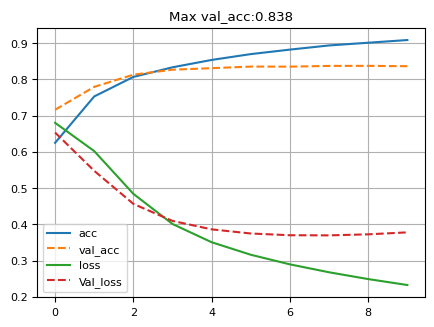

In [19]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.title(f"Max val_acc:{max(val_acc):.3f}")
plt.plot(acc, '-', label="acc")
plt.plot(val_acc, '--', label="val_acc")
plt.plot(loss, '-', label='loss')
plt.plot(val_loss, '--', label='Val_loss')
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()
plt.show()

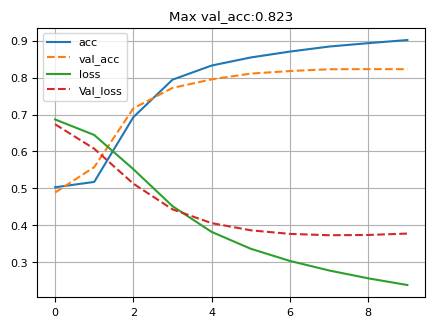

## Visualize the embeddings


### 학습된 word embeddings 저장하기  


In [20]:
model.layers

[<TextVectorization name=text_vectorization_1, built=True>,
 <Embedding name=embedding_1, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [21]:
weights = model.get_layer(index=1).get_weights()[0] #(10000,8)
vocab = vectorize_layer.get_vocabulary() #['','[UNK]','the','and',...]

In [22]:
ps(weights,'embedding table') #(10000,8)
p(vocab[:10])

<<embedding table>> Shape(10000, 8)
Type: <class 'list'>
Values: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a'), np.str_('of'), np.str_('to'), np.str_('is'), np.str_('in'), np.str_('it')]


**embedding layer의 weight를 저장**   
- [Embedding Projector](http://projector.tensorflow.org)를 사용하기위해 탭으로 구분된 형식으로 두 개의 파일에 저장   
- vectors.tsv(임베딩 포함)과 metadata.tsv(단어 포함)을 업로드합니다.



In [23]:
for index, word in enumerate(vocab[:4]):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  print('token:', word )
  print('vector:',vec)

token: [UNK]
vector: [ 0.07072525  0.156457   -0.761823    0.09132377 -0.00779163  0.08215113
 -0.19337104 -0.1716536 ]
token: the
vector: [-0.01608359  0.16515501 -0.87629473  0.05022413  0.03548142  0.16613089
 -0.3832048  -0.27900705]
token: and
vector: [-0.01740351  0.03332978 -0.5288755  -0.04442038  0.07650816  0.20463789
 -0.25291863 -0.24209385]


In [24]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')  #(10000,8)
out_m = io.open('metadata.tsv', 'w', encoding='utf-8') # tokens

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

* File을 Local로 download

In [25]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualize the embeddings

[Embedding Projector](http://projector.tensorflow.org/)
* "Load data"를 click하고,

* local에 download한 `vecs.tsv`, `meta.tsv`. upload  
  
 "wonderful"을 search해 보자.  
  근처에서 "amazing"같은 단어를 볼 수 있음  

참고: 더 간단한 모델을 사용하여 더 해석 가능한 임베딩을 생성할 수 있음  
 레이어를 Dense(16) 삭제하고, 모델을 다시 학습시키고, 임베딩을 다시 시각화해 보자  

참고: 일반적으로 더 해석 가능한 단어 임베딩을 학습하려면 훨씬 더 큰 데이터 세트가 필요함,  
여기서는 데모를 위해 작은 IMDb 데이터 세트를 사용하였음

### 해석이 쉬운 embedding 만들기  

In [26]:
#embedding_dim=8

model = Sequential([
  keras.Input(shape=(1,), dtype=tf.string),
  vectorize_layer,                     #(bs,100)
  Embedding(vocab_size, embedding_dim),#(bs,10000,8)
  GlobalAveragePooling1D(),            #(bs,8)
  Dense(1,'sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,009 (312.54 KB)

 Trainable params: 80,009 (312.54 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Training  

In [27]:
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5627 - loss: 0.6876 - val_accuracy: 0.6716 - val_loss: 0.6642
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7000 - loss: 0.6540 - val_accuracy: 0.7260 - val_loss: 0.6201
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7463 - loss: 0.6054 - val_accuracy: 0.7554 - val_loss: 0.5731
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7779 - loss: 0.5542 - val_accuracy: 0.7782 - val_loss: 0.5314
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8013 - loss: 0.5084 - val_accuracy: 0.7944 - val_loss: 0.4980
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8147 - loss: 0.4707 - val_accuracy: 0.8060 - val_loss: 0.4718
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8281 - loss: 0.4400 - val_accuracy: 0.8140 - val_loss: 0.4513
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8378 - loss: 0.4148 - val_accuracy: 0.8204 - v

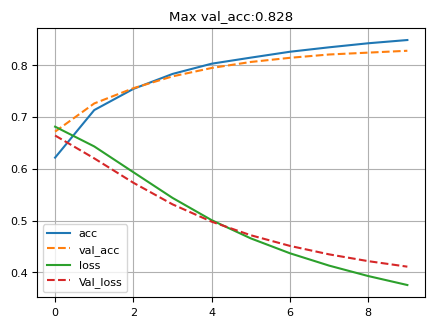

In [28]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.title(f"Max val_acc:{max(val_acc):.3f}")
plt.plot(acc, '-', label="acc")
plt.plot(val_acc, '--', label="val_acc")
plt.plot(loss, '-', label='loss')
plt.plot(val_loss, '--', label='Val_loss')
plt.legend()
plt.grid()
plt.show()

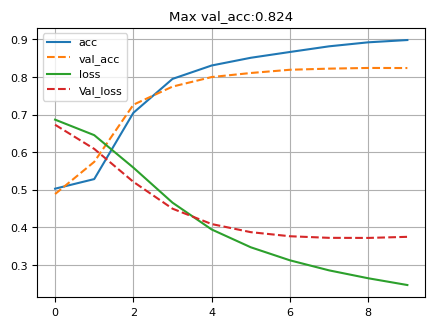

In [29]:
model.layers

[<TextVectorization name=text_vectorization_1, built=True>,
 <Embedding name=embedding_2, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d_1, built=True>,
 <Dense name=dense_2, built=True>]

In [30]:
weights = model.get_layer(index=1).get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

**embedding layer의 weight를 저장**   
- [Embedding Projector](http://projector.tensorflow.org)를 사용하기위해 탭으로 구분된 형식으로 두 개의 파일에 저장   
- vectors.tsv(임베딩 포함)과 metadata.tsv(단어 포함)을 업로드합니다.



"wonderful"이란 단어를 찾으면, 주변에서 "amazing"을 발견할 수 있음

In [31]:
for index, word in enumerate(vocab[:3]):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  print('token:', word )
  print('vector:',vec)

token: [UNK]
vector: [ 0.22957073 -0.17765674 -0.19326553  0.23659432  0.15846626 -0.16479611
  0.24024847 -0.16722421]
token: the
vector: [-0.02767756  0.02859966  0.0090791  -0.04893557 -0.05845101  0.0457138
  0.01903635  0.02332418]


In [32]:
out_v = io.open('vectors2.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata2.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [33]:
try:
  from google.colab import files
  files.download('vectors2.tsv')
  files.download('metadata2.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>